# Preprocessing Healthcare Device Data for Anomaly Detection

This notebook file focuses on preprocessing raw physiological and motion data collected from wearable devices in the **PPG-DaLiA dataset** to prepare it for unsupervised anomaly detection using the **Isolation Forest** algorithm. The preprocessing process ensures that the data is cleaned, segmented, and transformed into meaningful features for modeling and evaluation. The steps involved are as follows:

### 1. **Data Loading**
   - Reads the data path from the specified file location.
   - Ensures the data path is loaded correctly and contains the data for all participants in the PPG-DaLiA dataset.
   - Iterates through the participant folders to load their .pkl files, which contain raw signals, including:
     - **Blood Volume Pulse (BVP)**: Used for heart rate and cardiovascular analysis.
     - **Accelerometer (ACC)**: Measures motion along three axes (`x`, `y`, `z`).
     - **Temperature (TEMP)**: Captures skin temperature data.
   - The raw data contains the following keys:
     - **`rpeaks`**: Array of detected R-peaks in the ECG signal.
     - **`signal`**: Contains physiological and motion signals from wearable devices:
       - **Wrist Signals**:
         - **`BVP`**: Blood Volume Pulse signal.
         - **`ACC`**: Accelerometer data.
         - **`TEMP`**: Skin temperature data.
       - **Chest Signals** (not used in this pipeline): Includes ECG, EMG, EDA, temperature, and respiration data.
     - **`label`**: Ground truth heart rate (BPM).
     - **`activity`**: Activity annotations corresponding to the recorded signals.
     - **`questionnaire`**: Metadata such as weight, gender, age, and other participant details.

### 2. **Signal Segmentation**
   - Segments the raw signals into **8-second windows** with a **2-second overlap**.
   - This step ensures that the data is divided into manageable chunks for feature extraction and anomaly detection.
   - Each segment is aligned with its corresponding activity and heart rate labels.

### 3. **Activity Data Integration**
   - Processes activity logs from csv files to map activity names, like walking or cycling, to activity IDs.
   - Merges activity data with the segmented signals based on timestamps to provide contextual information for each segment.

### 4. **Feature Extraction**
   - Extracts meaningful features from the segmented BVP, ACC, and TEMP signals, including:
     - **Statistical Features**: Mean, standard deviation, kurtosis, etc.
     - **Frequency-Domain Features**: Key frequency components of the BVP signal.
     - **Contextual Features**: Activity labels and heart rate (BPM).
   - These features are designed to capture patterns and irregularities in the data, which are critical for anomaly detection.
   - The new patient dataframes, containing the extracted features, were saved as .pkl files for ease of use in subsequent modeling and analysis. This ensures efficient access to preprocessed data during the anomaly detection pipeline.

This preprocessing pipeline ensures that the raw data is transformed into a structured format with relevant features, enabling the detection of anomalies in device and patient data.

Python library dependencies: *NumPy, Pandas, Sklearn, Matplotlib, Seaborn*

In [128]:
import numpy as np
import pandas as pd
import os
import pickle
from scipy.fft import fft
from scipy.signal import resample
import seaborn as sns

The BVP (Blood Volume Pulse) and ACC (Accelerometer) segments represent processed portions of raw physiological and motion data collected from wearable devices. Here's what they signify:

# BVP Segments:

- Represent the blood volume pulse signal, which is used to measure heart rate and other cardiovascular metrics.
- Each segment is an 8-second window of the BVP signal, sampled at 64 Hz, with a 2-second overlap between consecutive segments.
- These segments are used for feature extraction, such as mean, standard deviation, and frequency-domain analysis.

# ACC Segments:

- Represent the accelerometer data, which measures motion in three axes (x, y, z).
- Each segment is an 8-second window of the ACC signal, sampled at 32 Hz, with a 2-second overlap.
- These segments are used to analyze physical activity and motion patterns, as well as to correlate motion with physiological signals like BVP.

In [129]:
data_path = "../data/PPG_FieldStudy" # Replace with your actual data path
if not data_path:
    raise ValueError("Data path not found.")

print(f"Data path: {data_path}") 

Data path: ../data/PPG_FieldStudy


In [130]:
if not os.path.exists(data_path):
    raise FileNotFoundError(f"The specified data path does not exist: {data_path}")
if not os.path.isdir(data_path):
    raise NotADirectoryError(f"The specified data path is not a directory: {data_path}")

patient_folders = [os.path.join(data_path, folder) for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]

# Make sure data path is correct, should output 15
print(f"Found {len(patient_folders)} patient folders in the data path.")


Found 15 patient folders in the data path.


## Initial Patient Dataframe Creation & Signal Segmentation

In [131]:
patient_dataframes = {}

def segment_signal(signal, window_size, step_size, sampling_rate):
    num_samples = len(signal)
    window_samples = int(window_size * sampling_rate)
    step_samples = int(step_size * sampling_rate)
    segments = [
        signal[i:i + window_samples]
        for i in range(0, num_samples - window_samples + 1, step_samples)
    ]
    return segments

for folder in patient_folders:
    patient_id = os.path.basename(folder)
    pkl_file = os.path.join(folder, f"{patient_id}.pkl")
    
    if not os.path.exists(pkl_file):
        print(f"Warning: .pkl file not found for patient {patient_id}. Skipping...")
        continue

    # Load the .pkl file
    try:
        with open(pkl_file, "rb") as file:
            data = pickle.load(file, encoding="latin1")  
    except Exception as e:
        print(f"Error decoding .pkl file for patient {patient_id}: {e}")
        continue
    
    # Extract necessary parts
    try:
        labels = data.get("label", [])
        wrist_signals = data.get("signal", {}).get("wrist", {})
        bvp_signal = wrist_signals.get("BVP", [])
        acc_signal = wrist_signals.get("ACC", [])
        temp_signal = wrist_signals.get("TEMP", [])  # Add TEMP data extraction

        
        # Ensure signals are numpy arrays for easier processing
        bvp_signal = np.array(bvp_signal)
        acc_signal = np.array(acc_signal)
        temp_signal = np.array(temp_signal)  # Convert TEMP to numpy array
        labels = np.array(labels)
        
        # Segment signals using an 8-second window with a 2-second shift
        bvp_segments = segment_signal(bvp_signal, window_size=8, step_size=2, sampling_rate=64)
        acc_segments = segment_signal(acc_signal, window_size=8, step_size=2, sampling_rate=32)
        temp_segments = segment_signal(temp_signal, window_size=8, step_size=2, sampling_rate=4)  # Adjust sampling rate if needed

        # Ensure the number of segments matches the labels
        min_segments = min(len(bvp_segments), len(acc_segments))
        bvp_segments = bvp_segments[:min_segments]
        acc_segments = acc_segments[:min_segments]
        temp_segments = temp_segments[:min_segments]
        labels = labels[:min_segments]
        
        # Create a DataFrame for the patient
        df = pd.DataFrame({
            "label": labels, #represents ground truth heart rate
            "bvp_segment": bvp_segments,
            "acc_segment": acc_segments,
            "temp_segment": temp_segments, 
        })
        
        # Store the DataFrame
        patient_dataframes[patient_id] = df
        # Each row represent a 2 second segment of the signal
        print(f"Processed data for patient {patient_id}.")
    
    except Exception as e:
        print(f"Error processing patient {patient_id}: {e}")



Processed data for patient S1.
Processed data for patient S10.
Processed data for patient S11.
Processed data for patient S12.
Processed data for patient S13.
Processed data for patient S14.
Processed data for patient S15.
Processed data for patient S2.
Processed data for patient S3.
Processed data for patient S4.
Processed data for patient S5.
Processed data for patient S6.
Processed data for patient S7.
Processed data for patient S8.
Processed data for patient S9.


In [132]:
# Example: Access the DataFrame for a specific patient
if patient_dataframes:
    example_patient_id = list(patient_dataframes.keys())[1]
    print(patient_dataframes[example_patient_id].head())
else:
    print("No patient dataframes were created.")

       label                                        bvp_segment  \
0  64.282356  [[7.87], [7.03], [6.33], [5.69], [4.94], [3.97...   
1  63.349710  [[-4.87], [-6.29], [-7.72], [-9.19], [-10.68],...   
2  64.568477  [[-19.77], [-21.86], [-24.02], [-26.2], [-28.1...   
3  64.671709  [[20.47], [26.46], [33.5], [40.85], [47.83], [...   
4  65.310046  [[38.82], [39.69], [39.95], [39.72], [39.2], [...   

                                         acc_segment  \
0  [[-0.765625, 0.25, 0.59375], [-0.765625, 0.265...   
1  [[-0.78125, 0.234375, 0.5625], [-0.78125, 0.25...   
2  [[-0.78125, 0.28125, 0.5625], [-0.765625, 0.28...   
3  [[-0.796875, 0.1875, 0.5625], [-0.765625, 0.21...   
4  [[-0.78125, 0.234375, 0.5625], [-0.78125, 0.23...   

                                        temp_segment  
0  [[30.61], [30.61], [30.59], [30.59], [30.59], ...  
1  [[30.61], [30.61], [30.61], [30.61], [30.61], ...  
2  [[30.61], [30.61], [30.61], [30.61], [30.61], ...  
3  [[30.61], [30.61], [30.63], [30.63], 

## Activity Data Integration

In [133]:
import os
import pandas as pd

# Directory containing activity files for all patients
activity_dir = "../data/PPG_FieldStudy"  # Replace with the correct directory path

# Map activity names to IDs
activity_mapping = {
    "NO_ACTIVITY": 0,
    "CLEAN_BASELINE": 1,
    "STAIRS": 2,
    "SOCCER": 3,
    "CYCLING": 4,
    "DRIVING": 5,
    "LUNCH": 6,
    "WALKING": 7,
    "WORKING": 8,
}

# Dictionary to store processed activity data for each patient
all_activity_data = {}

# Walk through all subdirectories and files in the activity directory
for root, dirs, files in os.walk(activity_dir):
    for filename in files:
        if filename.endswith("_activity.csv"):  # Process only activity files
            patient_id = filename.split("_")[0]  # Extract patient ID (e.g., "S1" from "S1_activity.csv")
            file_path = os.path.join(root, filename)  # Full path to the file
            # Read the file and remove the '#' character from each line
            activity_data = pd.read_csv(
                file_path,
                header=None,  # No header row in the data
                names=["activity", "timestamp"],  # Define column names
                skiprows=1  # Skip the first line with the subject ID
            )
            
            # Remove the '#' character from the 'activity' column
            activity_data["activity"] = activity_data["activity"].str.strip("# ")
            
            # Map activity names to IDs
            activity_data["activity_id"] = activity_data["activity"].map(activity_mapping)
            
            # Store the processed data in the dictionary
            all_activity_data[patient_id] = activity_data

# Example: Access the activity data for a specific patient
example_patient_id = "S1"  # Replace with the desired patient ID
if example_patient_id in all_activity_data:
    print(f"Activity data for {example_patient_id}:")
    print(all_activity_data[example_patient_id].describe())
else:
    print(f"No activity data found for patient {example_patient_id}.")

Activity data for S1:
         timestamp  activity_id
count    18.000000    17.000000
mean   3939.833333     2.117647
std    3400.754436     2.825826
min       0.000000     0.000000
25%    1146.250000     0.000000
50%    2633.000000     0.000000
75%    7517.250000     4.000000
max    9198.000000     8.000000


In [134]:
for patient_id, patient_df in patient_dataframes.items():
    if patient_id in all_activity_data:
        activity_df = all_activity_data[patient_id]
        
        # Ensure the activity DataFrame is sorted by timestamp
        activity_df = activity_df.sort_values(by="timestamp").reset_index(drop=True)
        
        # Forward-fill activity_id to cover all timestamps
        activity_df["activity_id"] = activity_df["activity_id"].fillna(method="ffill")
        
        # Use the patient DataFrame's index as the timestamp
        patient_df = patient_df.reset_index()  # Reset index to access row numbers
        patient_df["timestamp"] = patient_df.index * 2  # Multiply index by 2 seconds (adjust if needed)
        
        # Merge activity_id into the patient DataFrame using the timestamp
        patient_df = pd.merge_asof(
            patient_df.sort_values(by="timestamp"),  # Sort patient DataFrame by timestamp
            activity_df[["timestamp", "activity_id"]],  # Only keep relevant columns
            on="timestamp",  # Match timestamps
            direction="backward"  # Match the closest earlier activity timestamp
        )
        
        # Restore the original index and drop unnecessary columns
        patient_df = patient_df.set_index("index").drop(columns=["timestamp"])
        patient_dataframes[patient_id] = patient_df  # Update the patient DataFrame
        
        print(f"Activity data added to patient {patient_id}.")
    else:
        print(f"No activity data found for patient {patient_id}.")

Activity data added to patient S1.
Activity data added to patient S10.
Activity data added to patient S11.
Activity data added to patient S12.
Activity data added to patient S13.
Activity data added to patient S14.
Activity data added to patient S15.
Activity data added to patient S2.
Activity data added to patient S3.
Activity data added to patient S4.
Activity data added to patient S5.
Activity data added to patient S6.
Activity data added to patient S7.
Activity data added to patient S8.
Activity data added to patient S9.


In [135]:
patient_df.columns

Index(['label', 'bvp_segment', 'acc_segment', 'temp_segment', 'activity_id'], dtype='object')

## Feature Selection:

For this project, these are the type of features we want:
- Statistically meaningful: Mean, std, skewness, kurtosis, etc.
- Domain-relevant: Features that align with the physiological and motion data (e.g., BVP and ACC summaries, correlations).
- Interpretable: Features that are easy to explain and analyze.

Here are the 22 features we extracted:
1. BVP Features: mean, std, min, max, energy, ptp (peak-to-peak amplitude), skewness, kurtosis, freq_1, freq_2, freq_3
2. ACC Features: x_mean, y_mean, acc_z_mean, acc_x_std, acc_y_std, acc_z_std, acc_magnitude_mean, acc_magnitude_std
3. Correlation: bvp_acc_corr_mean
4. Contextual: activity, bpm

The preprocessed data is well-structured to capture both:

- Patient health metrics for physiological and motion analysis.
- Device performance metrics to evaluate the reliability and accuracy of the wearable devices.

In [136]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.fft import fft

# Function to calculate safe correlation
def safe_correlation(array1, array2):
    if np.std(array1) == 0 or np.std(array2) == 0:
        return 0  # Default to 0 if one array is constant
    return np.corrcoef(array1.ravel(), array2.ravel())[0, 1]

# Function to extract features from BVP, ACC, and TEMP segments
def extract_features(bvp_segment, acc_segment, temp_segment, activity_label, bpm):
    bvp_segment_resampled = bvp_segment

    # Split ACC into x, y, z axes
    acc_x = acc_segment[:, 0]
    acc_y = acc_segment[:, 1]
    acc_z = acc_segment[:, 2]

    # Compute vector magnitude for ACC
    acc_magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

    # Convert TEMP data to Fahrenheit
    temp_segment_fahrenheit = (temp_segment * 9/5) + 32

    # TEMP features
    temp_mean = np.mean(temp_segment_fahrenheit)
    temp_std = np.std(temp_segment_fahrenheit)
    temp_range = np.ptp(temp_segment_fahrenheit)

    # Extract features
    features = {
        # BVP features
        "bvp_mean": np.mean(bvp_segment_resampled),
        "bvp_std": np.std(bvp_segment_resampled),
        "bvp_energy": np.sum(bvp_segment_resampled ** 2),
        "bvp_ptp": np.ptp(bvp_segment_resampled),
        "bvp_freq_1": np.abs(fft(bvp_segment_resampled))[0],
        "bvp_freq_2": np.abs(fft(bvp_segment_resampled))[1],
        "bvp_freq_3": np.abs(fft(bvp_segment_resampled))[2],
        "bvp_kurtosis": float(kurtosis(bvp_segment_resampled)),

        # ACC features
        "acc_x_mean": np.mean(acc_x),
        "acc_x_std": np.std(acc_x),
        "acc_y_mean": np.mean(acc_y),
        "acc_y_std": np.std(acc_y),
        "acc_z_mean": np.mean(acc_z),
        "acc_z_std": np.std(acc_z),
        "acc_magnitude_mean": np.mean(acc_magnitude),
        "acc_magnitude_std": np.std(acc_magnitude),

        # TEMP features
        "temp_mean": temp_mean,
        "temp_std": temp_std,
        "temp_range": temp_range,

        # Contextual features
        "activity": activity_label,
        "bpm": bpm,
    }
    return features

# Variable to save the processed data
output_dir = "../processed_data"
os.makedirs(output_dir, exist_ok=True)

# Process and save features for each patient
for patient_id, patient_df in patient_dataframes.items():
    print(f"Processing patient: {patient_id}")
    extracted_features = []

    for _, row in patient_df.iterrows():
        # Extract the necessary segments
        bvp_segment = np.array(row["bvp_segment"])
        acc_segment = np.array(row["acc_segment"])
        temp_segment = np.array(row["temp_segment"])
        activity_label = row["activity_id"]
        bpm = row["label"]

        # Feature extraxtion
        features = extract_features(bvp_segment, acc_segment, temp_segment, activity_label, bpm)
        extracted_features.append(features)

    # Create a dataframe with the extracted features
    features_df = pd.DataFrame(extracted_features)

    # Save the dataframe as a .pkl file for easier access in model training
    output_path = os.path.join(output_dir, f"{patient_id}_processed.pkl")
    with open(output_path, "wb") as file:
        pickle.dump(features_df, file)
    print(f"Saved processed data for patient {patient_id} to {output_path}")

Processing patient: S1
Saved processed data for patient S1 to ../processed_data\S1_processed.pkl
Processing patient: S10
Saved processed data for patient S10 to ../processed_data\S10_processed.pkl
Processing patient: S11
Saved processed data for patient S11 to ../processed_data\S11_processed.pkl
Processing patient: S12
Saved processed data for patient S12 to ../processed_data\S12_processed.pkl
Processing patient: S13
Saved processed data for patient S13 to ../processed_data\S13_processed.pkl
Processing patient: S14
Saved processed data for patient S14 to ../processed_data\S14_processed.pkl
Processing patient: S15
Saved processed data for patient S15 to ../processed_data\S15_processed.pkl
Processing patient: S2
Saved processed data for patient S2 to ../processed_data\S2_processed.pkl
Processing patient: S3
Saved processed data for patient S3 to ../processed_data\S3_processed.pkl
Processing patient: S4
Saved processed data for patient S4 to ../processed_data\S4_processed.pkl
Processing p

## Save New Patient Dataframes

After extracting the most relevant features and creating new dataframes for each patient, each dataframe is saved as a .pkl file to reuse for the modeling process.

In [137]:
# import pickle

# # Directory to save the processed data
# output_dir = "../processed_data"  # Replace with your desired directory
# os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# # Save each patient's DataFrame as a .pkl file
# for patient_id, df in patient_dataframes.items():
#     output_path = os.path.join(output_dir, f"{patient_id}_processed.pkl")
#     with open(output_path, "wb") as file:
#         pickle.dump(df, file)
#     print(f"Saved processed data for patient {patient_id} to {output_path}")

In [138]:
for patient_id, features_df in features_df.items():
    print(f"Patient {patient_id} has {len(features_df)} rows.")

Patient bvp_mean has 4277 rows.
Patient bvp_std has 4277 rows.
Patient bvp_energy has 4277 rows.
Patient bvp_ptp has 4277 rows.
Patient bvp_freq_1 has 4277 rows.
Patient bvp_freq_2 has 4277 rows.
Patient bvp_freq_3 has 4277 rows.
Patient bvp_kurtosis has 4277 rows.
Patient acc_x_mean has 4277 rows.
Patient acc_x_std has 4277 rows.
Patient acc_y_mean has 4277 rows.
Patient acc_y_std has 4277 rows.
Patient acc_z_mean has 4277 rows.
Patient acc_z_std has 4277 rows.
Patient acc_magnitude_mean has 4277 rows.
Patient acc_magnitude_std has 4277 rows.
Patient temp_mean has 4277 rows.
Patient temp_std has 4277 rows.
Patient temp_range has 4277 rows.
Patient activity has 4277 rows.
Patient bpm has 4277 rows.


In [ ]:
# Outliers are important, so don't normalize the data yet!

# from sklearn.preprocessing import StandardScaler

# # Normalize the features
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features_df)

# # Convert back to a DataFrame for easier handling
# normalized_features_df = pd.DataFrame(scaled_features, columns=features_df.columns)
# print("Normalized features:")
# print(normalized_features_df.head())

In [ ]:
# from sklearn.ensemble import IsolationForest

# # Extract features for patient S1
# patient_1_features = all_features['S1']

# # Select numerical columns for anomaly detection
# numerical_columns = patient_1_features.select_dtypes(include=['float64', 'int64']).columns
# X = patient_1_features[numerical_columns]

# # Initialize Isolation Forest
# isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# # Fit the model and predict anomalies
# patient_1_features['anomaly'] = isolation_forest.fit_predict(X)

# # Add a column to indicate anomalies (1 for normal, -1 for anomaly)
# anomalies = patient_1_features[patient_1_features['anomaly'] == -1]

# # Define the activity mapping
# activity_mapping = {
#     0: "NO_ACTIVITY",
#     1: "CLEAN_BASELINE", # sitting
#     2: "STAIRS",
#     3: "SOCCER",
#     4: "CYCLING",
#     5: "DRIVING",
#     6: "LUNCH",
#     7: "WALKING",
#     8: "WORKING"
# }

# # Map activity IDs to labels in the anomalies DataFrame
# anomalies["activity_label"] = anomalies["activity"].map(activity_mapping)

# # Verify the conversion
# print(anomalies[["activity", "activity_label"]].head())

# # Print the number of anomalies detected
# print(f"Number of anomalies detected: {len(anomalies)}")
# print(anomalies.describe())

    activity activity_label
18       0.0    NO_ACTIVITY
19       0.0    NO_ACTIVITY
20       0.0    NO_ACTIVITY
21       0.0    NO_ACTIVITY
22       0.0    NO_ACTIVITY
Number of anomalies detected: 231
         bvp_mean     bvp_std      bvp_min      bvp_max    bvp_energy  \
count  231.000000  231.000000   231.000000   231.000000  2.310000e+02   
mean    -0.429857  142.149762  -487.407352   463.809374  6.511157e+06   
std      7.010102   72.118328   305.373591   319.349800  6.668897e+06   
min    -28.190742   46.533837 -1644.346543    96.277087  5.549958e+05   
25%     -3.467852   96.802378  -579.953196   254.727173  2.402877e+06   
50%     -0.331387  127.523834  -435.402339   397.075647  4.173239e+06   
75%      2.846523  175.475593  -288.954757   555.301325  7.883962e+06   
max     30.918887  341.529030  -104.950733  1554.202273  2.987486e+07   

           bvp_ptp  acc_x_mean   acc_x_std   acc_x_min   acc_x_max  ...  \
count   231.000000  231.000000  231.000000  231.000000  231.00000

C:\Users\darte\AppData\Local\Temp\ipykernel_35976\4268732413.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies["activity_label"] = anomalies["activity"].map(activity_mapping)


In [ ]:
# import seaborn as sns

# # Add the anomaly column to the numerical features DataFrame
# X["anomaly"] = patient_1_features["anomaly"]

# # Plot pairwise relationships, coloring by anomaly
# sns.pairplot(X, hue="anomaly", palette="coolwarm", diag_kind="kde")
# plt.show()

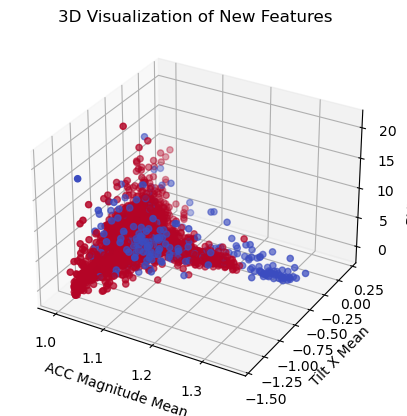

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(patient_1_features["acc_magnitude_mean"], patient_1_features["tilt_x_mean"], 
#            patient_1_features["bvp_kurtosis"], c=patient_1_features["anomaly"], cmap="coolwarm")
# ax.set_xlabel("ACC Magnitude Mean")
# ax.set_ylabel("Tilt X Mean")
# ax.set_zlabel("BVP Kurtosis")
# plt.title("3D Visualization of New Features")

# plt.show()